# Kernel Tuner Simulation Mode Test

This notebook is intended to examine the completeness, consistency, and advantage of simulation mode in Kernel Tuner.

In [1]:
from pathlib import Path
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from warnings import warn
from typing import Tuple

cachedirectory = Path("kernels/outputdata/simulation_mode")
savedirectory = Path(Path.cwd(), "figures", "simulation_mode")
mpl.rcParams["savefig.directory"] = savedirectory

In [2]:
# arguments
kernelname = "gemm_cltune_opencl"
expected_keys_env = ['execution_time', 'overhead_time', 'total_benchmark_time', 'total_verification_time', 'total_compile_time', 'total_strategy_time', 'total_framework_time']
expected_keys_cache = ['time', 'times', 'GFLOP/s', 'temperature', 'compile_time', 'benchmark_time', 'verification_time', 'framework_time', 'strategy_time']

algorithm_displaynames = {
    'brute': "bruteforce",
    'random': "random",
}
column_displaynames = {
    'compile_time': "Compile time",
    'benchmark_time': "Benchmark time",
    'verification_time': "Verification time",
    'strategy_time': "Strategy time",
    'framework_time': "Framework time",
    'total_time': "Total time"
}

plot_height = 6
plot_aspect = 2.0
plot_dpi = 250
sns.set_theme(rc={'figure.figsize':(plot_height*plot_aspect,plot_height)})

In [3]:
def get_dataframes() -> Tuple[pd.DataFrame, pd.DataFrame]:

    # collect the relevant cachefiles
    cachefiles : list[Path] = []
    for file in cachedirectory.iterdir():
        if file.is_file() and file.name.startswith(kernelname) and file.name.endswith('_output.json'):
            cachefiles.append(file)

    # create a list of dictionaries of the data
    cache_dicts = list()
    env_dicts = list()
    for filepath in cachefiles:
        # load the data
        envfilepath = Path(str(filepath).replace('_output', '_env'))
        assert envfilepath.exists()
        try:
            cachefile = json.load(filepath.open())
            envfile = json.load(envfilepath.open())
        except json.JSONDecodeError:
            warn(f"Could not load cachefile {filepath.name}")
            continue
        assert isinstance(cachefile, list)
        assert isinstance(envfile, dict)

        # combine the data into a dictionary
        device_name = envfile['device_name']
        is_simulated = "_mode=simulated" in filepath.name
        mode = 'simulated' if is_simulated else 'real'
        algorithm = algorithm_displaynames[re.search(r"_alg=([a-zA-Z]+)_", filepath.name).group(1).strip()]
        run_number = int(re.search(r"_#(\d+)_", filepath.name).group(1))
        # for each of the tuned configurations, create a dictionary with the expected items
        for value in cachefile:
            assert isinstance(value, dict)
            cache = {}
            cache['device_name'] = device_name
            cache['algorithm'] = algorithm
            cache['simulated'] = is_simulated
            cache['mode'] = mode
            cache['run_number'] = run_number
            for key in expected_keys_cache:
                cache[key] = value[key]
            cache['total_time'] = value['strategy_time'] + value['compile_time'] + value['benchmark_time'] + value['verification_time'] + value['framework_time']
            cache_dicts.append(cache)
        # create a global dictionary per tuning session
        env = {}
        env['device_name'] = device_name
        env['algorithm'] = algorithm
        env['simulated'] = is_simulated
        env['mode'] = mode
        env['number_of_configs'] = len(cachefile)
        env['run_number'] = run_number
        for key in expected_keys_env:
            env[key] = envfile[key]
        env_dicts.append(env)

    # create a dataframe out of the dictionaries
    df_cache = pd.DataFrame(cache_dicts)
    df_env = pd.DataFrame(env_dicts)
    return df_cache, df_env

In [4]:
df_cache, df_env = get_dataframes()
df_cache

,device_name,algorithm,simulated,mode,run_number,time,times,GFLOP/s,temperature,compile_time,benchmark_time,verification_time,framework_time,strategy_time,total_time
0,NVIDIA RTX A4000,random,False,real,28,37.456457,"[37.454848, 37.492736, 37.424127999999996, 37....",3670.195165,60.860806,48.795833,274.027352,0,0.000000,348.034834,670.858019
1,NVIDIA RTX A4000,random,False,real,28,66.350953,"[66.359264, 66.353152, 66.343936, 66.354176, 6...",2071.899519,60.424187,254.780273,469.728924,0,1.799234,0.008797,726.317228
2,NVIDIA RTX A4000,random,False,real,28,85.265691,"[85.269504, 85.26438399999999, 85.265344, 85.2...",1612.283975,60.882628,43.765492,604.157018,0,1.559067,0.010299,649.491876
3,NVIDIA RTX A4000,random,False,real,28,29.880613,"[29.622272, 29.971456, 29.599743999999998, 29....",4600.725891,60.000000,147.124338,213.646315,0,1.806258,0.010250,362.587161
4,NVIDIA RTX A4000,random,False,real,28,47.563630,"[47.562751999999996, 47.5648, 47.55968, 47.563...",2890.286312,60.327352,205.004366,348.231101,0,1.675074,0.010209,554.920750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11586,NVIDIA RTX A4000,random,False,real,43,20.729248,"[20.740095999999998, 20.726784, 20.719616, 20....",6631.813557,62.404035,464.812542,149.537121,0,1.566942,0.009237,615.925842
11587,NVIDIA RTX A4000,random,False,real,43,43.312567,"[43.283456, 43.321343999999996, 43.319296, 43....",3173.963537,62.182624,216.678542,308.161091,0,1.691774,0.010029,526.541437
11588,NVIDIA RTX A4000,random,False,real,43,39.356709,"[39.346176, 39.36768, 39.3472, 39.361536, 39.3...",3492.987927,62.725884,99.704251,280.163702,0,1.639448,0.009658,381.517059
11589,NVIDIA RTX A4000,random,False,real,43,24.882171,"[24.870912, 24.907743999999997, 24.87296, 24.9...",5524.940148,63.041807,99.426782,178.551452,0,1.620021,0.009928,279.608183


In [5]:
# fig = plt.gcf()
# fig.set_size_inches(9, plot_height)
# fig.set_dpi(plot_dpi)
# g = sns.countplot(data=df_cache, x='mode')
# g.set_ylabel("Number of configurations")
# g.bar_label(g.containers[0])
# plt.tight_layout()
# plt.savefig(savedirectory / "Q2_count")

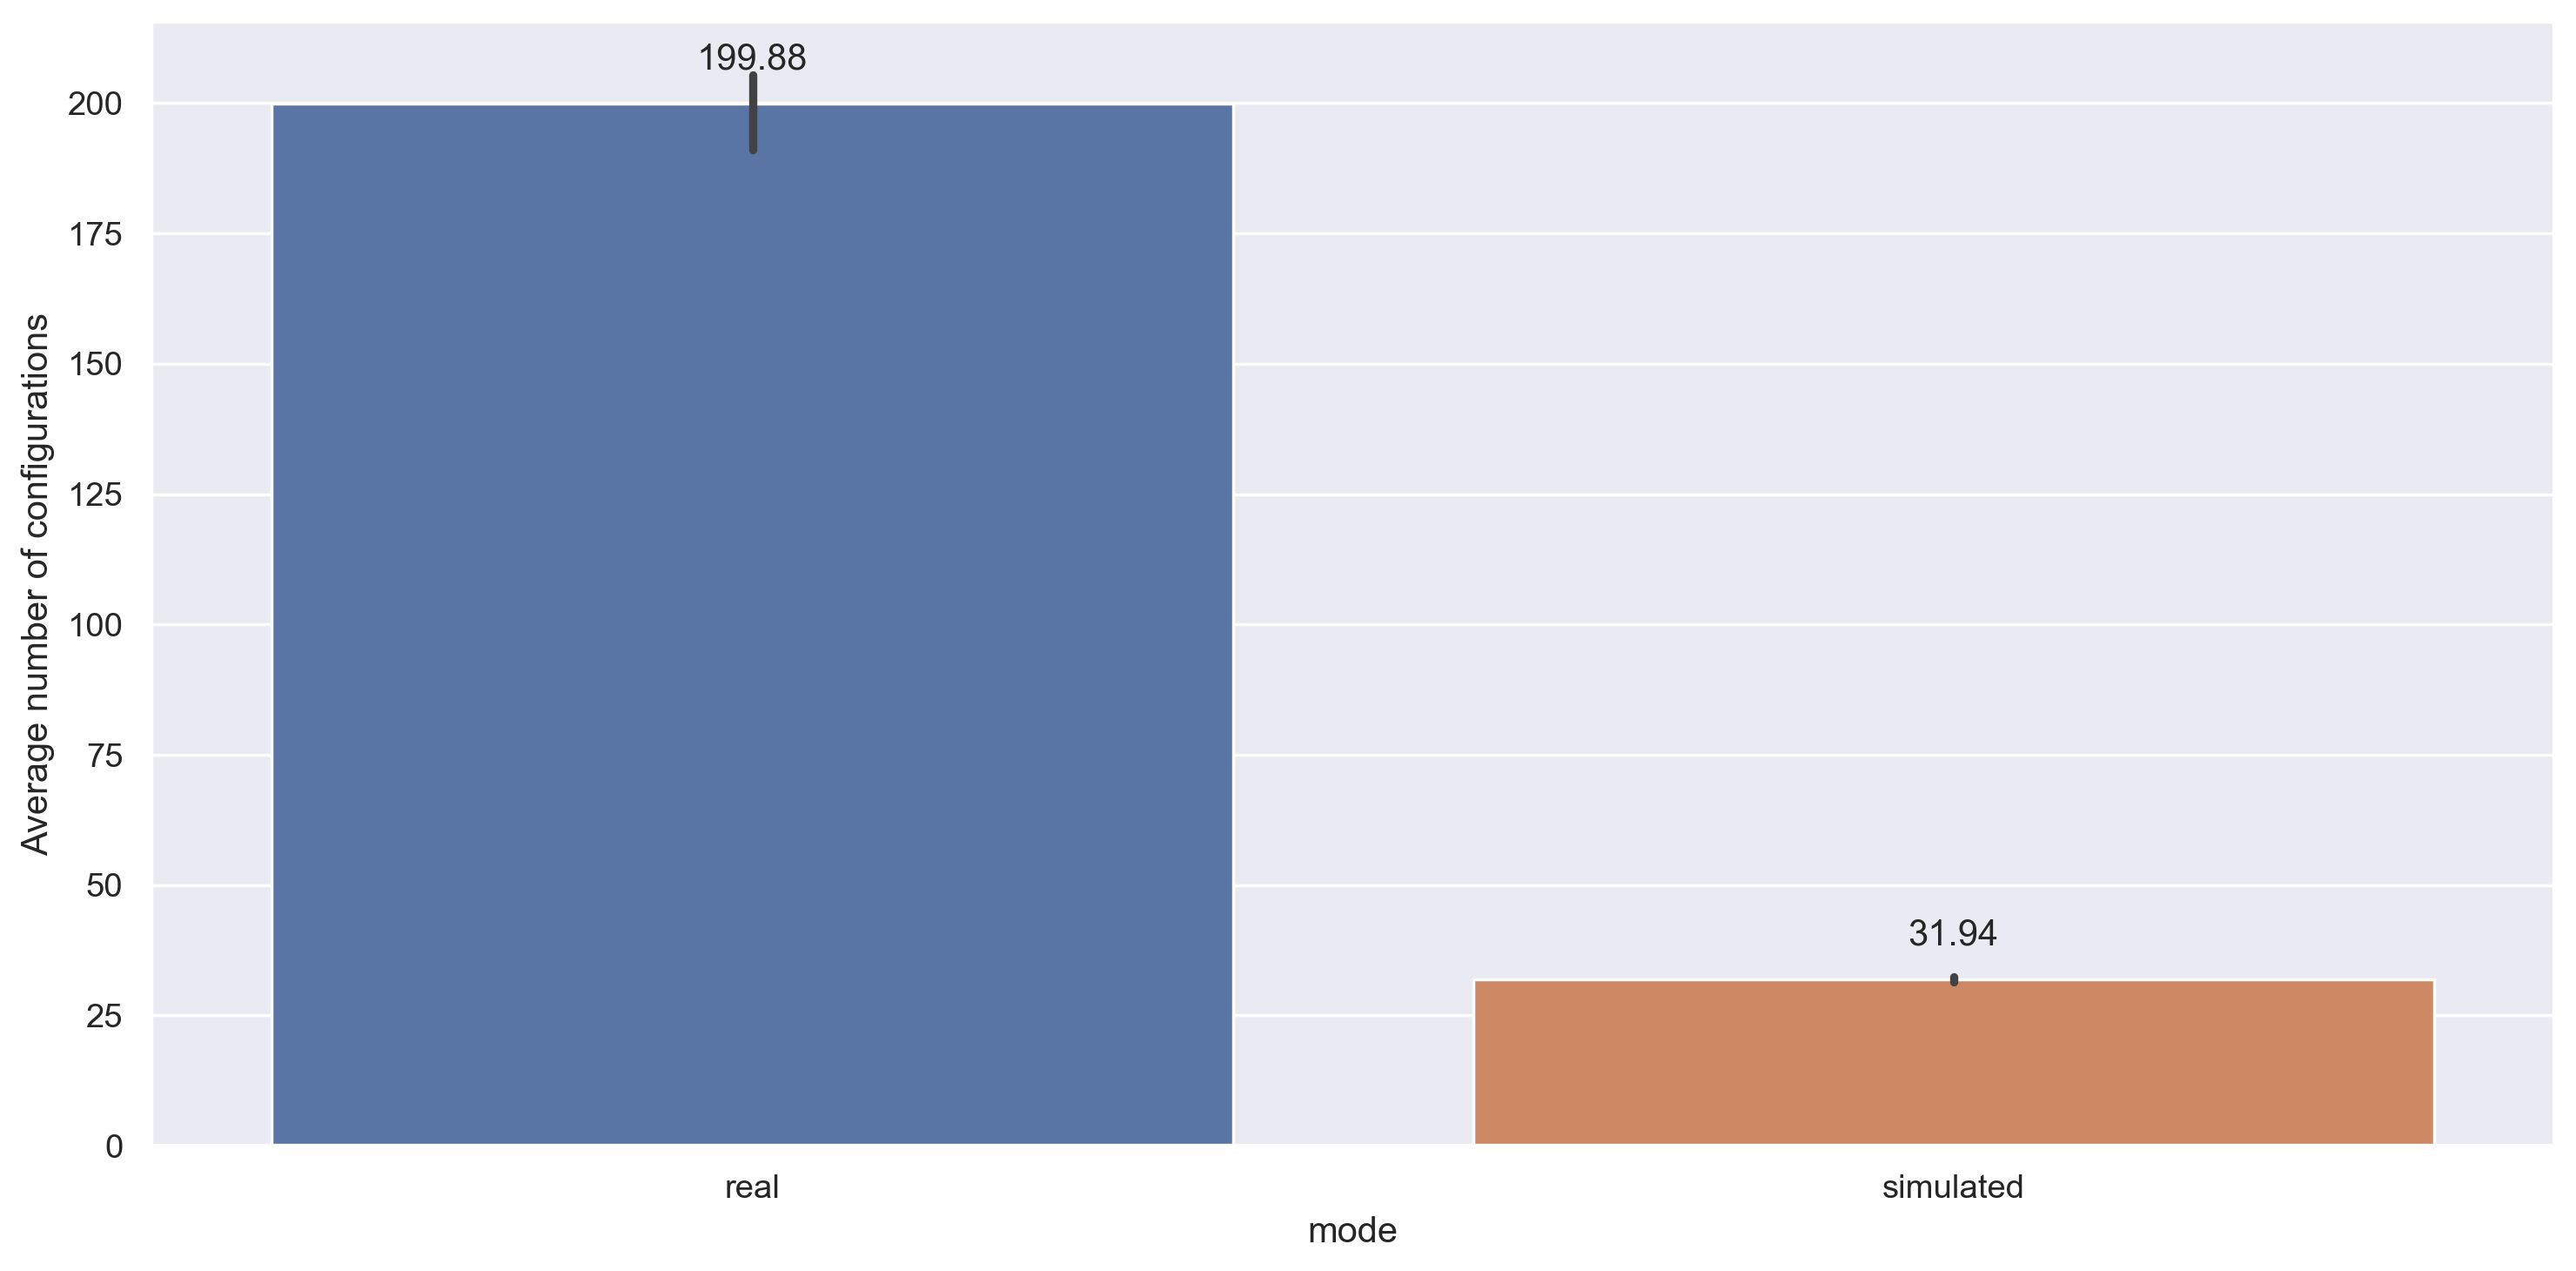

In [6]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=plot_dpi)
g = sns.barplot(data=df_env, x='mode', y='number_of_configs')
g.bar_label(g.containers[0], padding=9.0)
g.set_ylabel("Average number of configurations")
plt.tight_layout()
plt.savefig(savedirectory / "Q2_count")

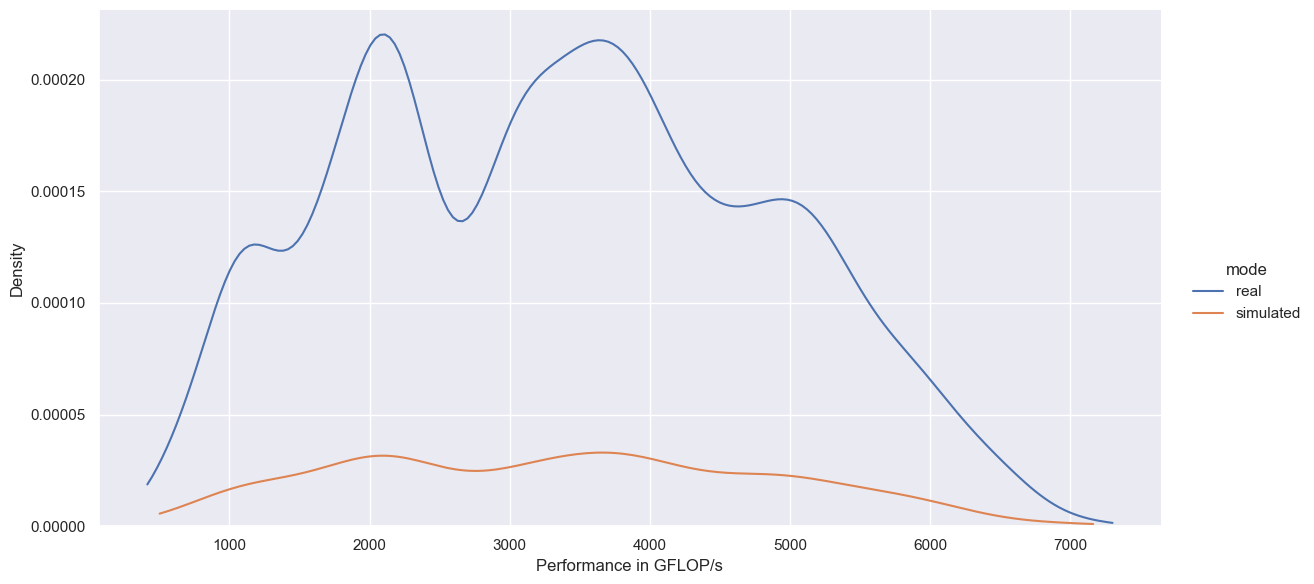

In [7]:
g = sns.displot(data=df_cache, x='GFLOP/s', hue='mode', kind='kde', fill=False, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Performance in GFLOP/s")
g.savefig(savedirectory / "Q2_performance_gflops")

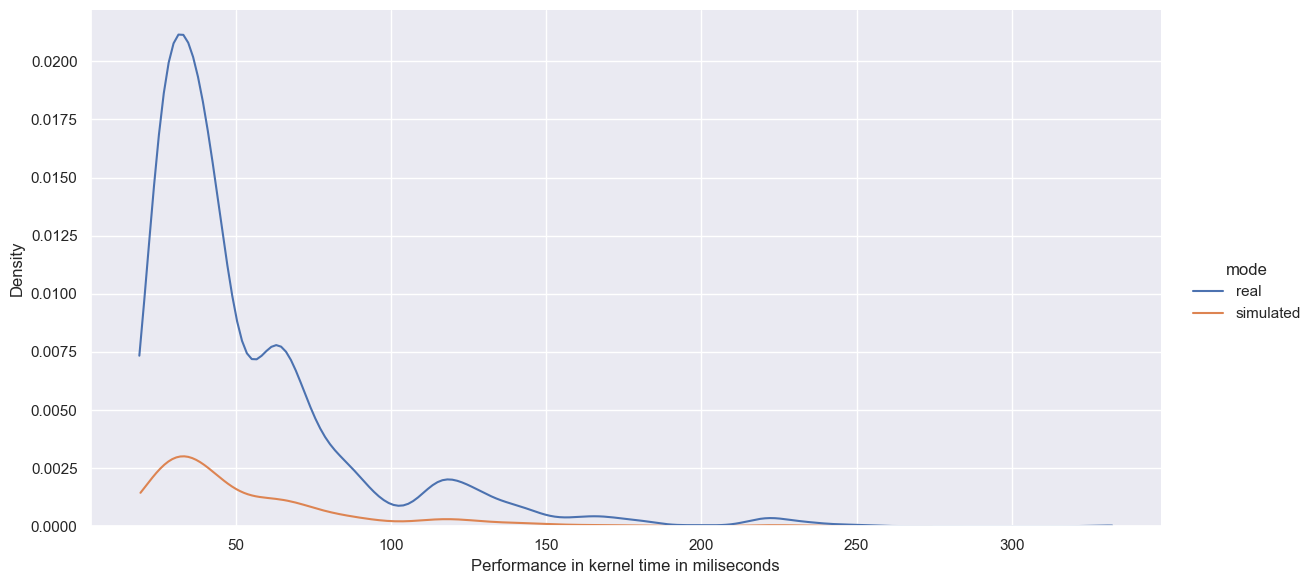

In [8]:
g = sns.displot(data=df_cache, x='time', hue='mode', kind='kde', fill=False, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Performance in kernel time in miliseconds")
g.savefig(savedirectory / "Q2_performance_time")

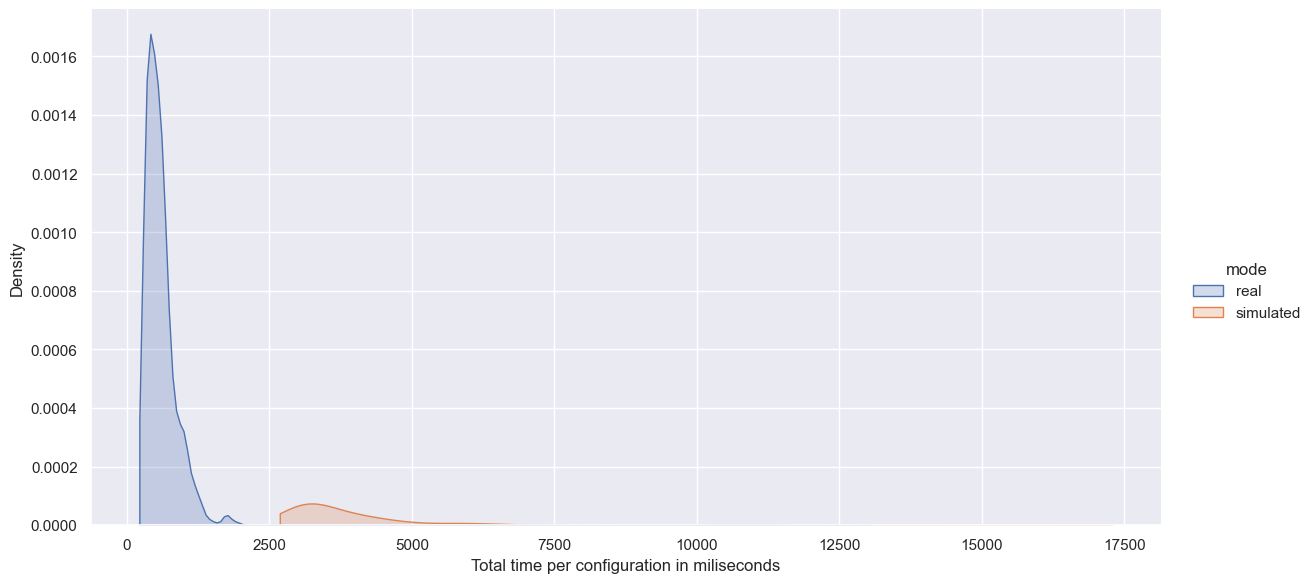

In [9]:
g = sns.displot(data=df_cache, x='total_time', hue='mode', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Total time per configuration in miliseconds")
# g.savefig(savedirectory / "performance_distribution_time_per_config")

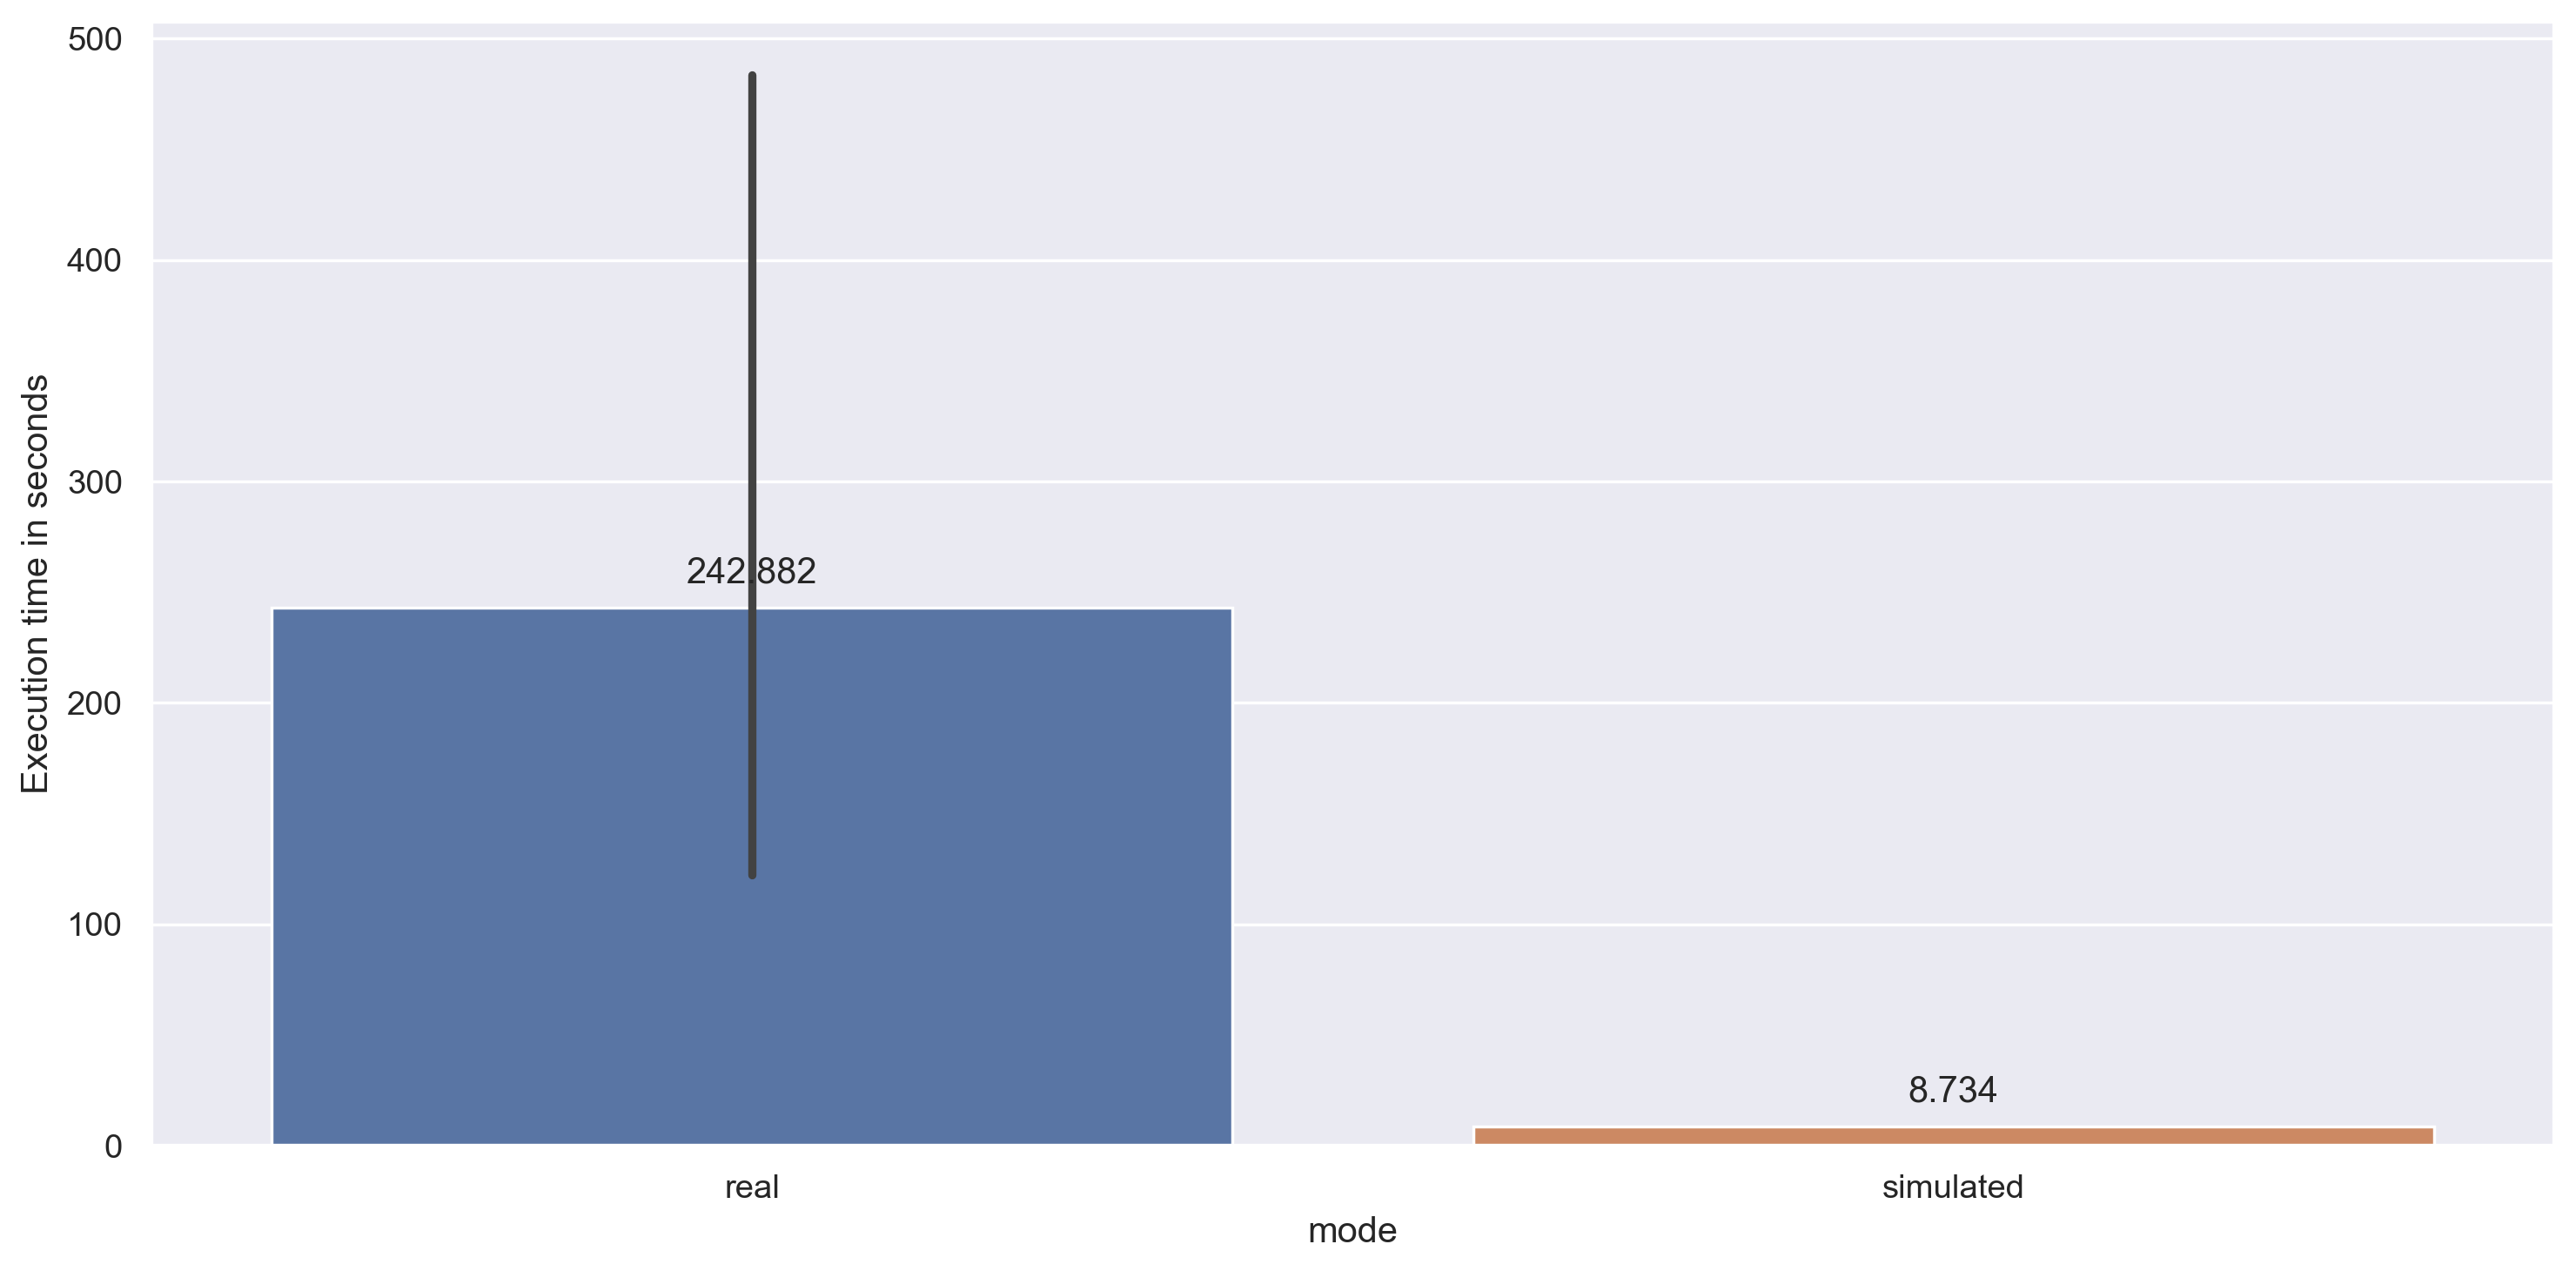

In [10]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=plot_dpi)
g = sns.barplot(data=df_env.round(1), x='mode', y="execution_time")
g.bar_label(g.containers[0], padding=6.0)
g.set_ylabel("Execution time in seconds")
plt.tight_layout()
plt.savefig(savedirectory / "Q3_execution_time_spent")

           compile_time  benchmark_time  verification_time  framework_time   
mode                                                                         
real         200.226750      382.250888                0.0        1.652258  \
simulated    258.618853     3555.107121                0.0        0.048136   

           strategy_time  
mode                      
real            4.873622  
simulated     238.750243  
           compile_time  benchmark_time  verification_time  framework_time   
mode                                                                         
real         173.550054      253.164084                0.0        7.072451  \
simulated    137.693919     1167.436201                0.0        0.016946   

           strategy_time  
mode                      
real          191.462040  
simulated    1329.796295  


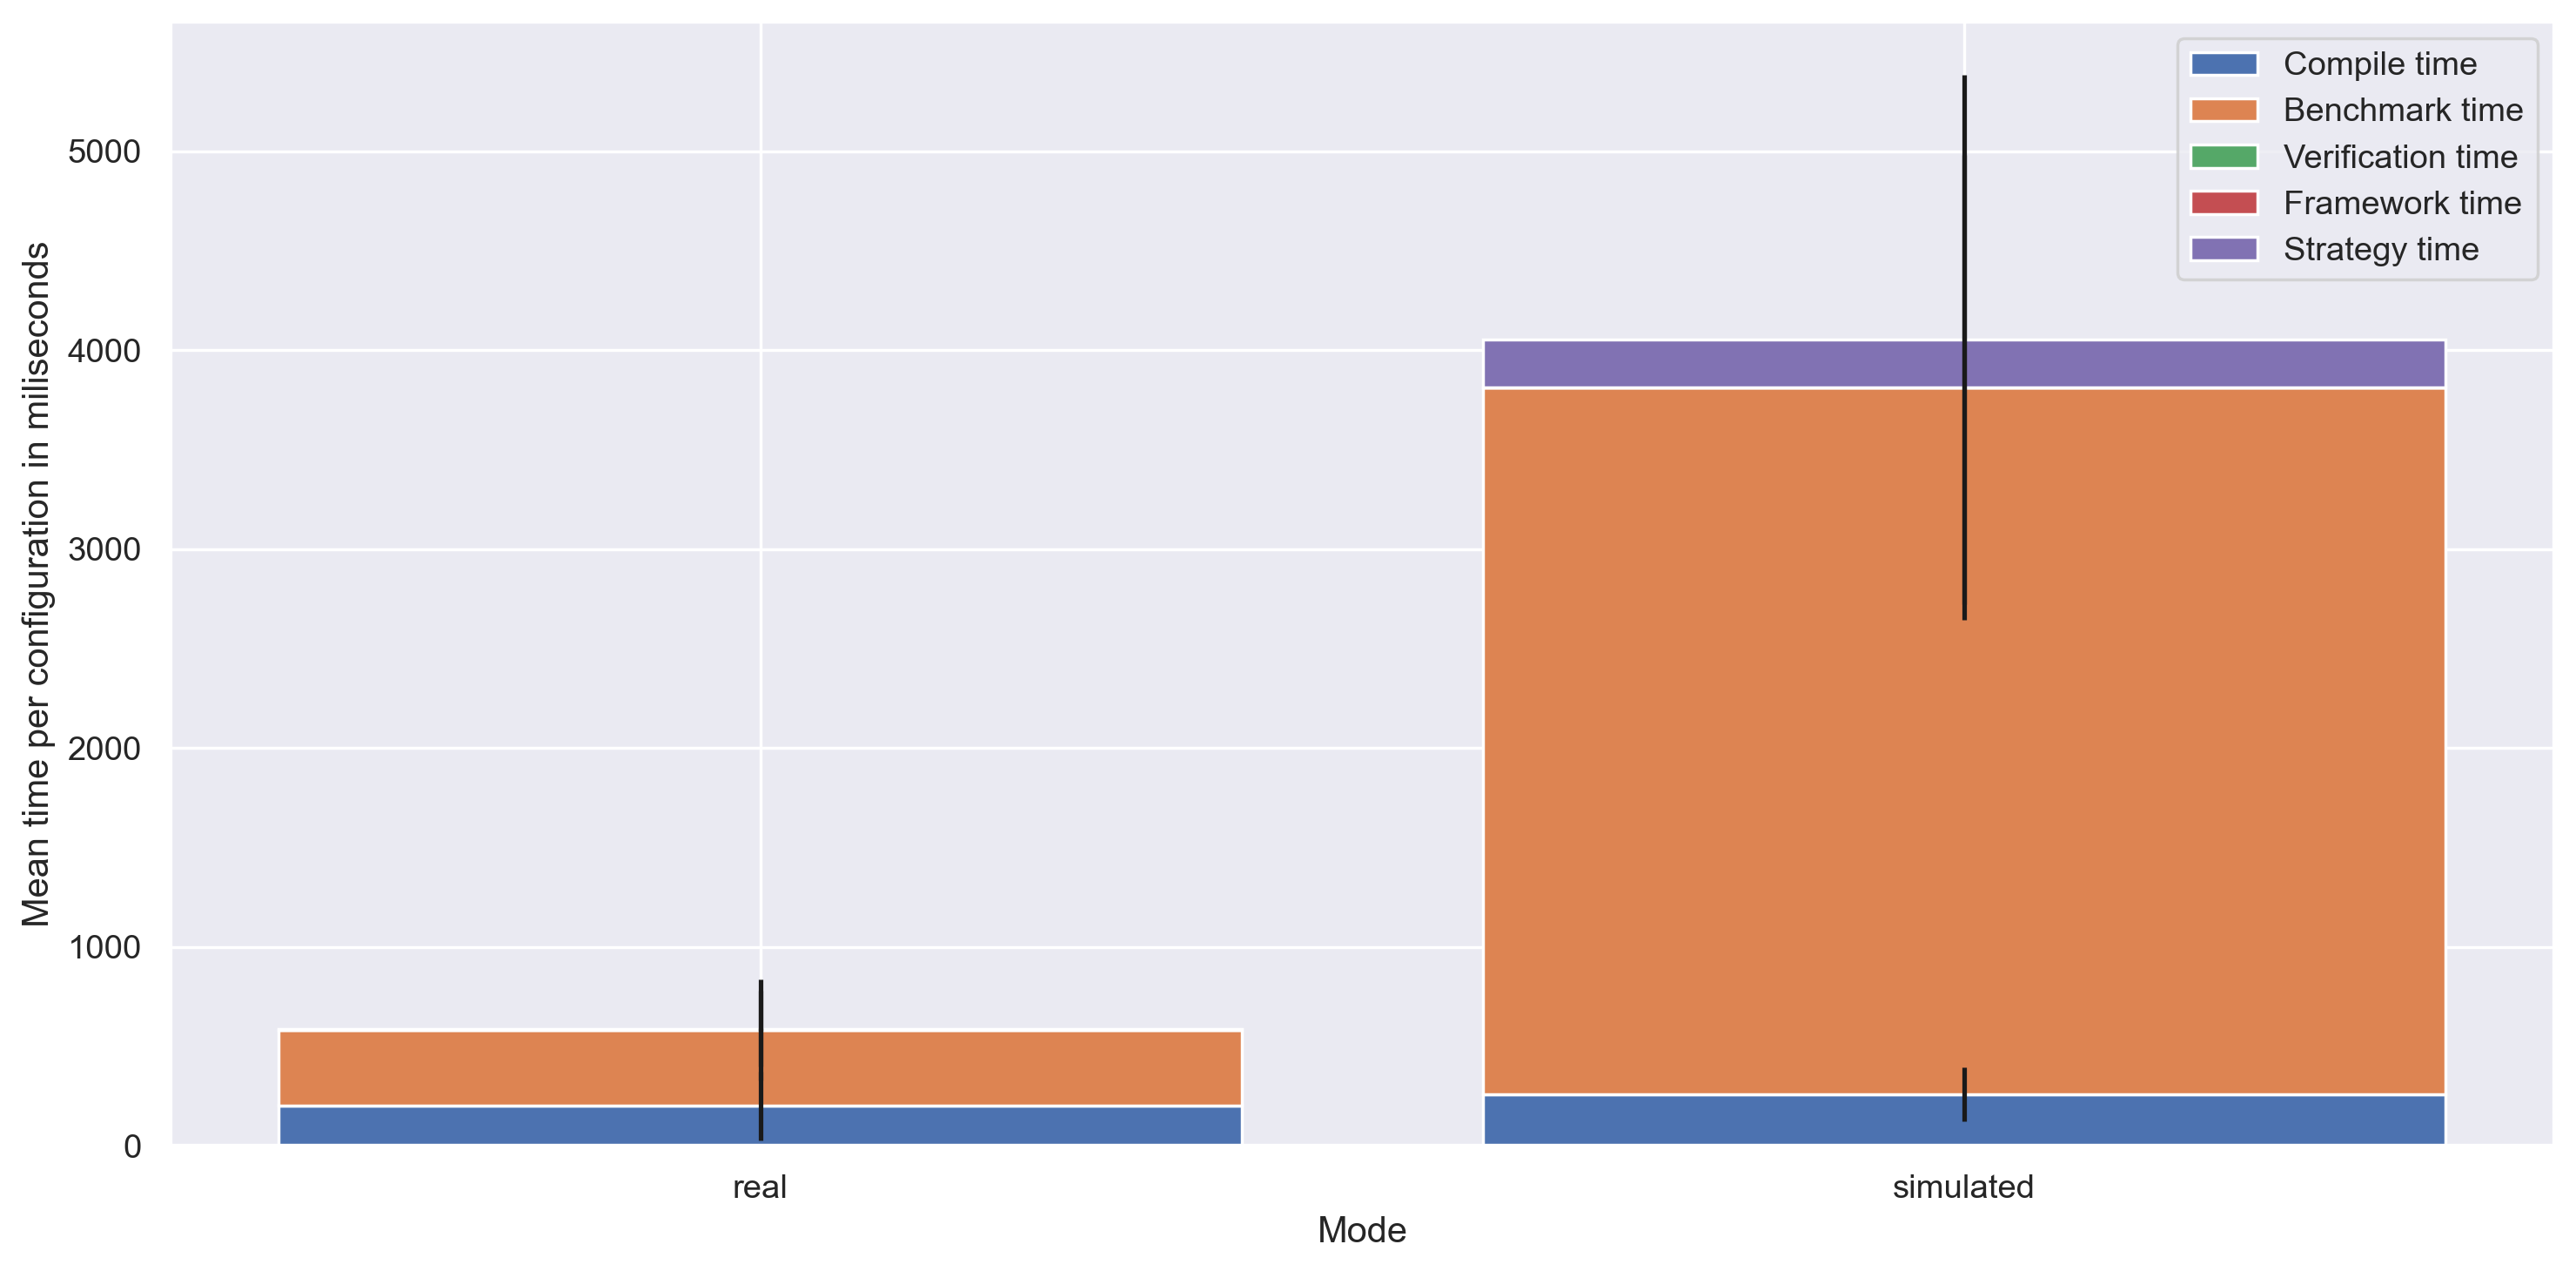

In [11]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=plot_dpi)
df_times = df_cache.filter(regex='_time|mode').drop(columns=['total_time'])
ind = df_times['mode'].unique()
prev = np.zeros(ind.shape)
times_avg = df_times.groupby('mode').mean()
times_std = df_times.groupby('mode').std()
print(times_avg)
print(times_std)
for series_name, _ in df_times.items():
    if '_time' in series_name:
        time_avg = np.array(times_avg[series_name])
        time_std = np.array(times_std[series_name])
        plt.bar(x=ind, height=time_avg, yerr=time_std, bottom=prev, label=column_displaynames[series_name])
        prev = time_avg + prev
plt.legend()
plt.xlabel("Mode")
plt.ylabel("Mean time per configuration in miliseconds")
plt.tight_layout()
plt.savefig(savedirectory / "Q1_time_spent_per_category")